[View in Colaboratory](https://colab.research.google.com/github/mrrajeshreddy/Carvana-Image-Masking/blob/master/Unet_Keras.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import os
import functools

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

#tf.enable_eager_execution()
data_dir = 'carvana-image-masking-challenge'
print(os.listdir(os.path.join('.',data_dir)))
print(tf.__version__)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

['train_masks.csv', 'sample_submission.csv.zip', 'train.zip', 'train_hq.zip', 'test.zip', 'train', 'test_hq.zip', 'train_masks', 'train_masks.csv.zip', '29bb3ece3180_11.jpg', 'train_masks.zip', 'metadata.csv.zip']
1.11.0


In [0]:
img_dir = os.path.join('.', data_dir, 'train')
label_dir = os.path.join('.', data_dir, 'train_masks')

In [0]:
df_train = pd.read_csv(os.path.join('.', data_dir,'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=10)

In [6]:
num_train_examples = len(x_train)
num_val_examples = len(x_val)
print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_val_examples}")

Number of training examples: 4070
Number of validation examples: 1018


In [7]:
x_train[:10]

['./carvana-image-masking-challenge/train/00087a6bd4dc_05.jpg',
 './carvana-image-masking-challenge/train/03a857ce842d_08.jpg',
 './carvana-image-masking-challenge/train/65051cfe0789_07.jpg',
 './carvana-image-masking-challenge/train/e1d2c25f3510_08.jpg',
 './carvana-image-masking-challenge/train/3c16409ab9db_16.jpg',
 './carvana-image-masking-challenge/train/8d78483ce302_01.jpg',
 './carvana-image-masking-challenge/train/0ee135a3cccc_14.jpg',
 './carvana-image-masking-challenge/train/6d77433cc7ce_06.jpg',
 './carvana-image-masking-challenge/train/34defeec3ce6_11.jpg',
 './carvana-image-masking-challenge/train/1952e5f91de0_10.jpg']

In [8]:
y_train[:10]

['./carvana-image-masking-challenge/train_masks/00087a6bd4dc_05_mask.gif',
 './carvana-image-masking-challenge/train_masks/03a857ce842d_08_mask.gif',
 './carvana-image-masking-challenge/train_masks/65051cfe0789_07_mask.gif',
 './carvana-image-masking-challenge/train_masks/e1d2c25f3510_08_mask.gif',
 './carvana-image-masking-challenge/train_masks/3c16409ab9db_16_mask.gif',
 './carvana-image-masking-challenge/train_masks/8d78483ce302_01_mask.gif',
 './carvana-image-masking-challenge/train_masks/0ee135a3cccc_14_mask.gif',
 './carvana-image-masking-challenge/train_masks/6d77433cc7ce_06_mask.gif',
 './carvana-image-masking-challenge/train_masks/34defeec3ce6_11_mask.gif',
 './carvana-image-masking-challenge/train_masks/1952e5f91de0_10_mask.gif']

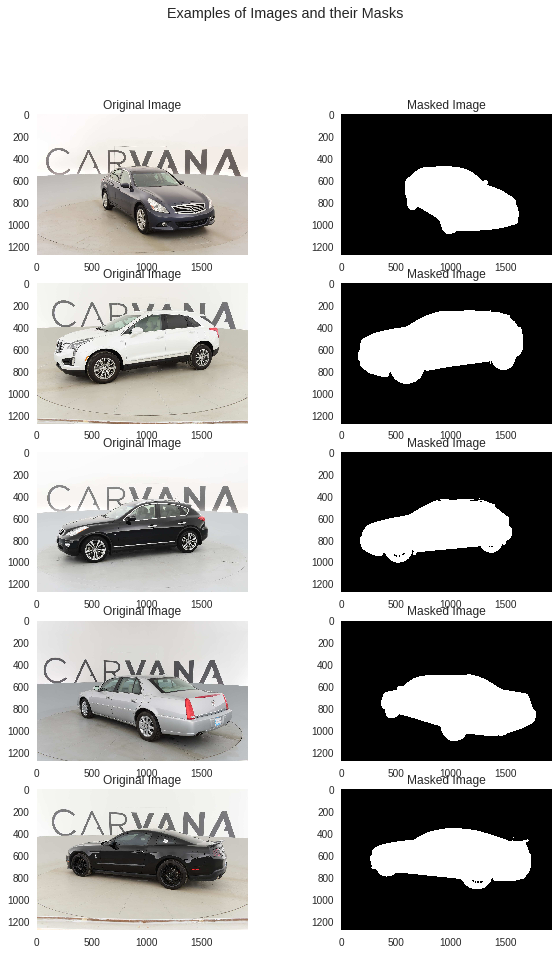

In [9]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train[img_num]
    y_pathname = y_train[img_num]
    plt.subplot(display_num, 2, i + 1)
    plt.imshow(mpimg.imread(x_pathname))
    plt.title("Original Image")
    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)
    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [0]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 10

In [0]:
def _process_files(image_path, label_path):
    img_str = tf.read_file(image_path)
    img = tf.image.decode_jpeg(img_str, channels=3)
        
    label_img_str = tf.read_file(label_path)
    # These are gif images so they return as (num_frames, h, w, c)
    label_img = tf.image.decode_gif(label_img_str)[0]
    # The label image should only have values of 1 or 0, indicating pixel wise
    # object (car) or not (background). We take the first channel only. 
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    return img, label_img

In [0]:
def _resize(image, label, size=[256,256]):
    label_img = tf.image.resize_images(label, size)
    image = tf.image.resize_images(image, size)
    return image, label_img

In [0]:
def _scale(image, label, scale=1/255):
    label_img = label * scale
    image = image * scale
    return image, label_img

In [0]:
def _image_flip(image, label, horizontal_flip):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        image, label = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                                lambda: (image, label))
    return image, label

In [0]:
def _image_shift(image, label, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
        if  height_shift_range:
            height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
        image = tfcontrib.image.translate(image,
                                             [width_shift_range, height_shift_range])
        label = tfcontrib.image.translate(label,
                                             [width_shift_range, height_shift_range])
    return image, label

In [0]:
def _augment(image, 
             label,
             resize=None,
             scale=1,
             hue_delta=0,
             horizontal_flip=False,
             width_shift_range=0,
             height_shift_range=0
            ):
    if resize is not None:
        image, label = _resize(image, label, size=resize)
    if hue_delta:
        image = tf.image.random_hue(image, hue_delta)
    image, label = _image_flip(image, label, horizontal_flip)
    image, label = _image_shift(image, label, width_shift_range, height_shift_range)
    image, label = _scale(image, label, scale=scale)
    return image, label

In [0]:
def get_dataset(filenames,
                labels, 
                threads=5, 
                batch_size=batch_size,
                shuffle=True,
                preproc_fn=functools.partial(_augment),
                resize=True,
                scale=1/255,
               ):
    num_x = 20
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_process_files, num_parallel_calls=threads)
    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
    if shuffle:
        dataset = dataset.shuffle(num_x)
    
    dataset = dataset.repeat().batch(batch_size ) #, drop_remainder=True)
    return dataset

In [0]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'horizontal_flip': False,
    'hue_delta': None,
    'width_shift_range': None,
    'height_shift_range': None
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

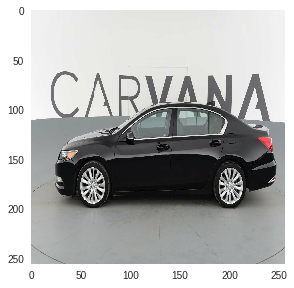

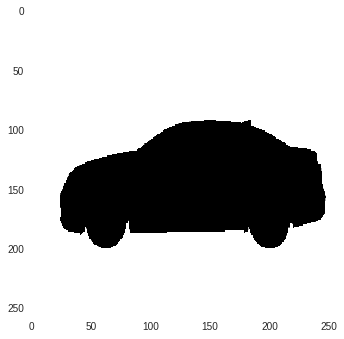

In [25]:
temp_ds = get_dataset(x_train, 
                      y_train,
                      preproc_fn=val_preprocessing_fn,
                      batch_size=1,
                      shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
    imgs, lbls = sess.run(next_element)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[0])
    plt.show()
    plt.subplot(1, 2, 2)
    plt.imshow(lbls[0,:,:,0])
    plt.show()

In [0]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

In [0]:
def get_model():
    inputs = layers.Input(shape=img_shape)
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
    center = conv_block(encoder4_pool, 1024)
    decoder4 = decoder_block(center, encoder4, 512)
    decoder3 = decoder_block(decoder4, encoder3, 256)
    decoder2 = decoder_block(decoder3, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    decoder0 = decoder_block(decoder1, encoder0, 32)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [0]:
#For TPU
#K.clear_session()
#tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#    model,
#    strategy=tf.contrib.tpu.TPUDistributionStrategy(
#        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#    )
#)
#tpu_model.compile(optimizer=tf.train.AdamOptimizer(), loss=bce_dice_loss, metrics=[dice_loss])
#tpu_model.summary()
#class ImageDataInput(object):
#  def __init__(self, is_training):
#    self.training = is_training
#  def input_fn(self):
#    if self.training:
#      return get_dataset(x_train,
#                         y_train,
#                         preproc_fn=tr_preprocessing_fn,
#                         batch_size=batch_size)
#    else:
#      return get_dataset(x_val,
#                         y_val, 
#                         preproc_fn=val_preprocessing_fn,
#                         batch_size=batch_size)
#
#train_data_input = ImageDataInput(is_training = True)
#val_data_input = ImageDataInput(is_training = False)
#history = tpu_model.fit(train_data_input.input_fn, 
#                        steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
#                        epochs=epochs,
#                        validation_data=val_data_input.input_fn,
#                        validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
#                        callbacks=[cp])

In [53]:
K.clear_session()
model = get_model()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
train_ds = get_dataset(x_train,
                       y_train,
                       preproc_fn=tr_preprocessing_fn,
                       batch_size=batch_size)
val_ds = get_dataset(x_val,
                     y_val, 
                     preproc_fn=val_preprocessing_fn,
                     batch_size=batch_size)

In [0]:
save_weight_path = './gdrive/My Drive/model/UNET_Keras_weigh.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_weight_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [58]:
history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp])

Epoch 1/10
1356/1357 [============================>.] - ETA: 0s - loss: 0.3827 - dice_loss: 0.0709
Epoch 00001: val_dice_loss improved from inf to 0.41556, saving model to ./gdrive/My Drive/model/UNET_Keras_weigh.h5
1357/1357 [==============================] - 698s 514ms/step - loss: 0.3826 - dice_loss: 0.0709 - val_loss: 10.7877 - val_dice_loss: 0.4156
Epoch 2/10
1356/1357 [============================>.] - ETA: 0s - loss: 0.1015 - dice_loss: 0.0172
Epoch 00002: val_dice_loss improved from 0.41556 to 0.02988, saving model to ./gdrive/My Drive/model/UNET_Keras_weigh.h5
1357/1357 [==============================] - 682s 503ms/step - loss: 0.1015 - dice_loss: 0.0172 - val_loss: 0.1810 - val_dice_loss: 0.0299
Epoch 3/10
1356/1357 [============================>.] - ETA: 0s - loss: 0.0775 - dice_loss: 0.0127
Epoch 00003: val_dice_loss did not improve from 0.02988
1357/1357 [==============================] - 679s 501ms/step - loss: 0.0778 - dice_loss: 0.0128 - val_loss: 8.7253 - val_dice_loss

In [0]:
model.save('./gdrive/My Drive/model/UNET_Keras_model_final.h5')

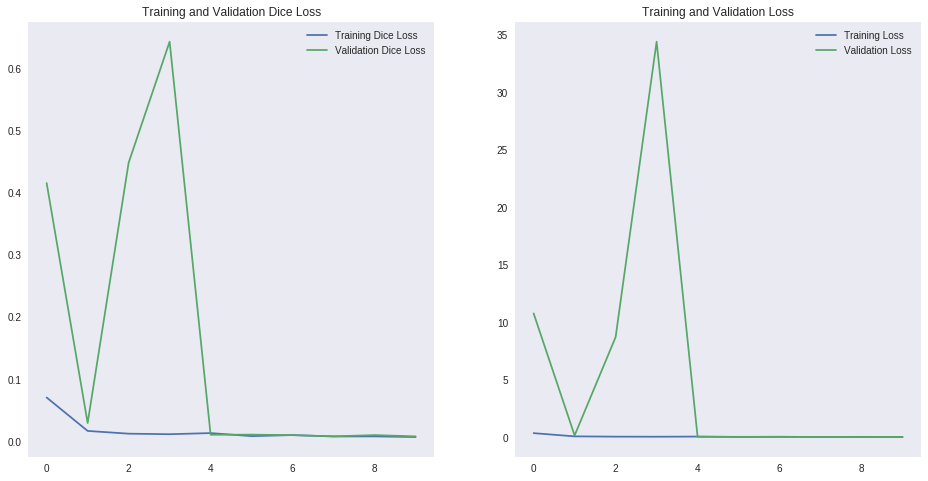

In [61]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

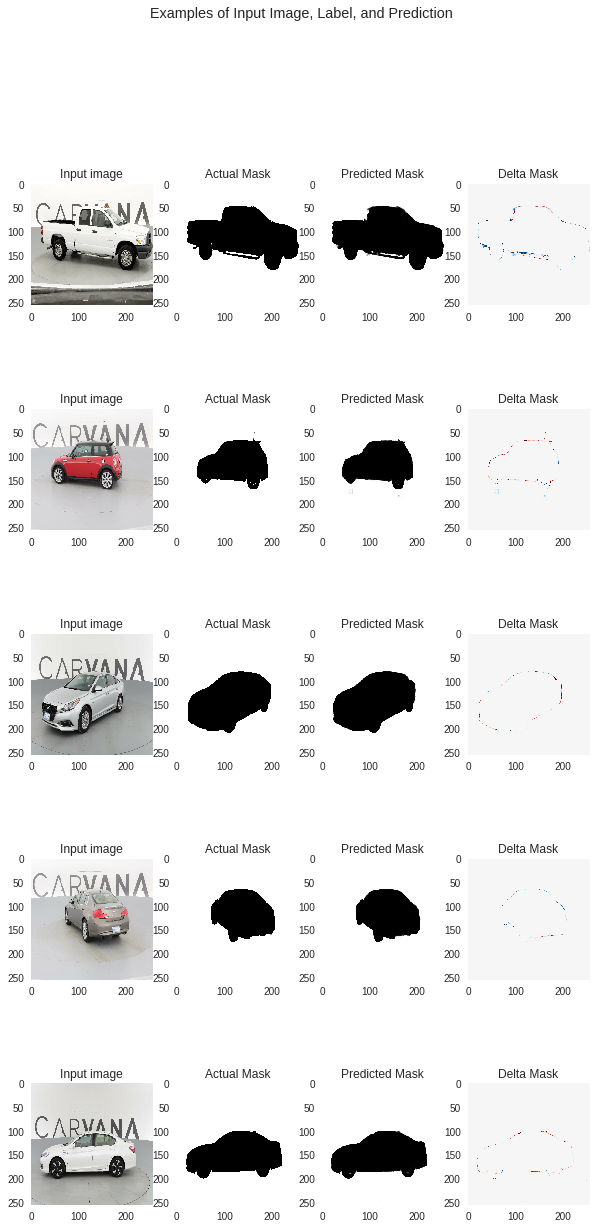

In [62]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
    #next_element = data_aug_iter.get_next() -- use this for eager
    img = batch_of_imgs[0]
    predicted_label = model.predict(batch_of_imgs)[0]
    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(img)
    plt.title("Input image")
    
    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(label[0, :, :, 0])
    plt.title("Actual Mask")
    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(predicted_label[:, :, 0])
    plt.title("Predicted Mask")
    plt.subplot(5, 4, 4 * i + 4)
    plt.imshow((predicted_label[:, :, 0]-label[0, :, :, 0]), cmap = 'RdBu', vmin = -1, vmax = 1)
    plt.title("Delta Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()